In [1]:
import src.generation.gamma as ga
import src.generation.multivariate_normal as mn

from src.salp.salp import SALP
from src.salp.salp import Node

import numpy as np
import matplotlib.pyplot as plt

## Example pipeline

Estimated minimal node power 30.0
Actual mean node load 29.662529940200727
-----------------------
Node 0: 1.0236035740404081


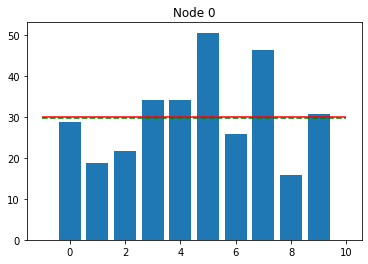

Node 1: 1.0163878759313467


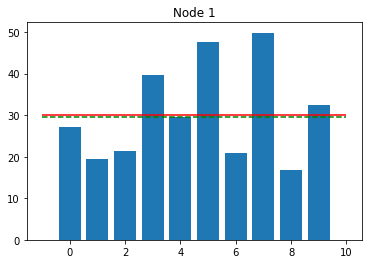

Node 2: 1.0024867014512147


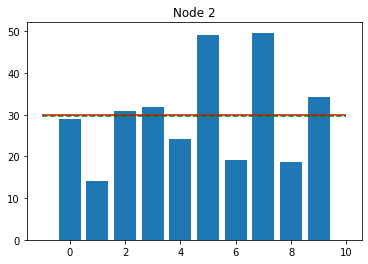

Node 3: 0.9125258406037936


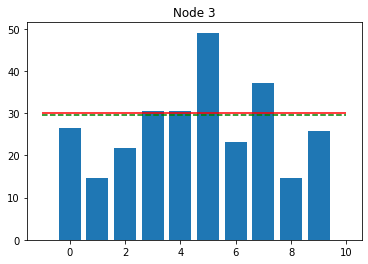

In [2]:
def pipeline(F: int, N: int, size: int, cor: float, rng = (2,4)):
    
    generator = ga.Generator(F, size, cor, rng)
    
    estimated_load = generator.get_estimated_cloud_load()
    estimated_node_load = estimated_load/size/N
    print("Estimated minimal node power", estimated_node_load)
    
    load_vectors = generator.generate_cloud_load_vectors()
    actual_mean_node_load = np.sum(load_vectors)/size/N
    print("Actual mean node load", actual_mean_node_load)
    
    cloud = SALP(N, load_vectors, False)
    assert len(cloud.nodes) == N
    
    print('-----------------------')
    
    for n in cloud.nodes:
        print("Node {}:".format(n.identity), np.mean(n.ws)/estimated_node_load)
        plt.bar(
            np.arange(size),
            n.ws
        )
        plt.title("Node {}".format(n.identity))
        plt.hlines(estimated_node_load, xmin=0-1, xmax=size, colors='r')
        plt.hlines(actual_mean_node_load, xmin=0-1, xmax=size, colors='g', linestyle='dashed')
        plt.show()
    
    
pipeline(20, 4, 10, 0.5)

### Walidacja SALP

----------------DESCRIPTION----------------
Shards:
[[3 1]
 [3 1]
 [3 1]
 [1 3]
 [1 3]
 [1 3]]

WTS:
[12 12]

NWTS:
[6. 6.]

LW:
[(0, 3.1622776601683795), (1, 3.1622776601683795), (2, 3.1622776601683795), (3, 3.1622776601683795), (4, 3.1622776601683795), (5, 3.1622776601683795)]


----------------ASSIGNMENT----------------
Shard ID: 0
Shard: [3 1]

	Node ID: 0
	Delta: 2.654329479393269

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 1
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 2
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 1.8309518948453007

Shard ID: 3
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 3.0025247700991105

Shard ID: 4
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 1.4142135623730951

Shard ID: 5
Shard: [1 3]

	Node ID: 1
	Delta: 1.4142135623730951

----------------FINAL NODES----------------
Node: 0
	Shards assigned [FS]: [0 2 4]
	

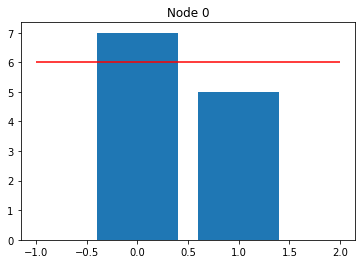

Node 1: 1.0


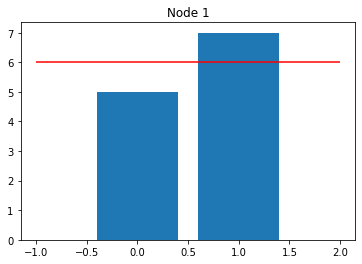

In [5]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = SALP(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plt.bar(
        np.arange(size),
        n.ws
    )
    plt.title("Node {}".format(n.identity))
    plt.hlines(mean_node_load, xmin=0-1, xmax=size, colors='r')
    plt.show()

# Parametry dla iteracji
* F - ilość shardów
* N - ilość węzłów
* cor - poziom korelacji miedzy wektorami obciążenia
* ro - poziom obciążenia chmury
* size - długość wektorów obciążenia
* parametry generatora do ustalenia